In [ ]:
%matplotlib inline

import pandas
import numpy
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

warnings.filterwarnings("ignore")

In [ ]:
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

In [ ]:
print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))
print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

Training data has 25192 rows & 42 columns
Testing data has 22544 rows & 41 columns


In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()

cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

sc_traindf = pandas.DataFrame(sc_train, columns = cols)
sc_testdf = pandas.DataFrame(sc_test, columns = cols)

In [ ]:
encoder = LabelEncoder()

cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [ ]:
train_x = pandas.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [ ]:
test_df = pandas.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

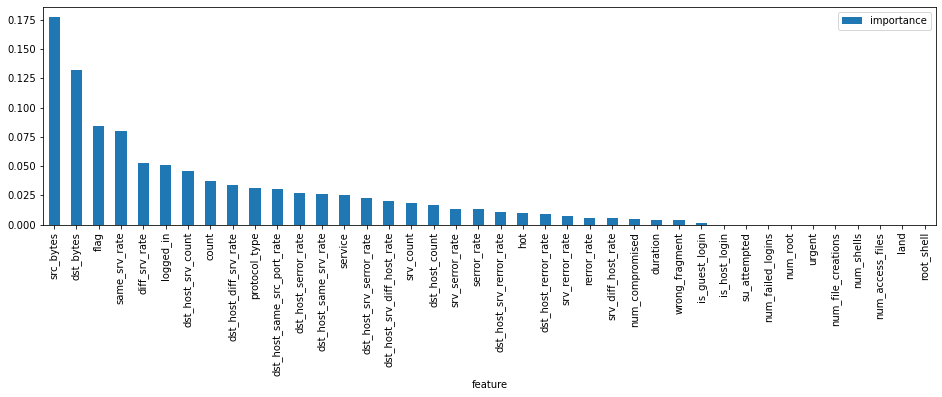

In [ ]:
rfc = RandomForestClassifier();

rfc.fit(train_x, train_y);

score = numpy.round(rfc.feature_importances_,3)
importances = pandas.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (16,4)
importances.plot.bar();

In [ ]:
imp_features = importances.head(10)
selected_features = list(imp_features.index)
selected_features

['src_bytes',
 'dst_bytes',
 'flag',
 'same_srv_rate',
 'diff_srv_rate',
 'logged_in',
 'dst_host_srv_count',
 'count',
 'dst_host_diff_srv_rate',
 'protocol_type']

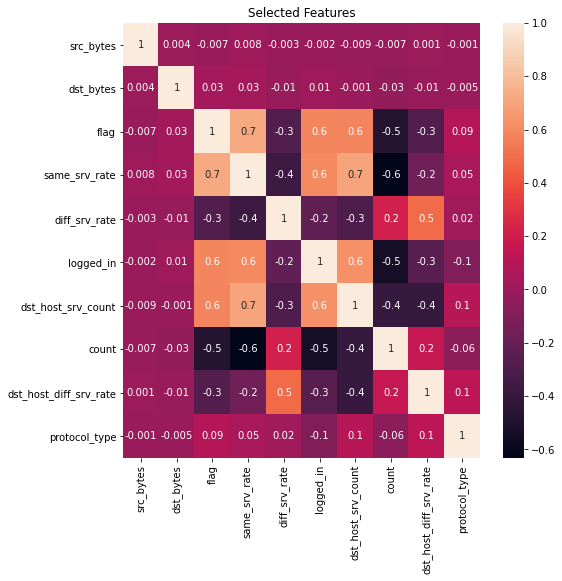

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
ax = seaborn.heatmap(train_x[selected_features].corr(), annot = True, fmt='.1g')
plt.title("Selected Features")
plt.show()

In [ ]:
train_x = train_x[selected_features]

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.80, random_state=2)

In [ ]:
test_pred = pandas.DataFrame()
test_pred['actual'] = Y_test.tolist()
test_pred

,actual
0,anomaly
1,anomaly
2,anomaly
3,anomaly
4,normal
...,...
5034,normal
5035,anomaly
5036,normal
5037,normal


In [ ]:
model_lr = LogisticRegression()
model_lr = model_lr.fit(X_train, Y_train)

In [ ]:
pred = model_lr.predict(X_test)

In [ ]:
pred

array(['anomaly', 'normal', 'anomaly', ..., 'normal', 'normal', 'anomaly'],
      dtype=object)

In [ ]:
metrics.confusion_matrix(Y_test, pred)

array([[2136,  197],
       [ 151, 2555]], dtype=int64)

In [ ]:
f1_lr = metrics.f1_score(Y_test, pred, pos_label="normal")

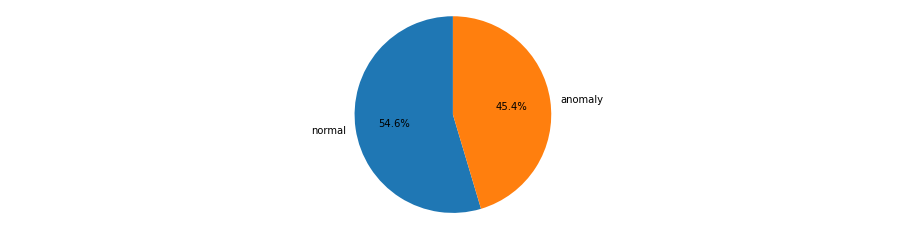

In [ ]:
test_pred['pred_lr'] = pred
ratio = test_pred['pred_lr'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
model_knn = KNeighborsClassifier(n_jobs=-1)
model_lr = LogisticRegression()
model_knn.fit(X_train, Y_train);

In [ ]:
scores = cross_val_score(model_knn, X_train, Y_train, cv=10)
accuracy = metrics.accuracy_score(Y_train, model_knn.predict(X_train))
f1_score = metrics.f1_score(Y_train, model_knn.predict(X_train), pos_label="normal")

print ("Cross Validation Mean Score:" "\n", scores.mean())
print ("Model Accuracy:" "\n", accuracy)
print ("F1-Score : " "\n", f1_score)

Cross Validation Mean Score:
 0.9788616132970972
Model Accuracy:
 0.9852131196347939
F1-Score : 
 0.9861214605067062


In [ ]:
accuracy = metrics.accuracy_score(Y_test, model_knn.predict(X_test))
f1_score = metrics.f1_score(Y_test, model_knn.predict(X_test), pos_label="normal")

print ("Model Accuracy:" "\n", accuracy)
print ("F1-Score : " "\n", f1_score)

Model Accuracy:
 0.9759872990672752
F1-Score : 
 0.9776464067984482


In [ ]:
prediction = model_knn.predict(X_test)
test_pred['pred_knn'] = prediction

In [ ]:
f1_knn = metrics.f1_score(Y_test, prediction, pos_label="normal")

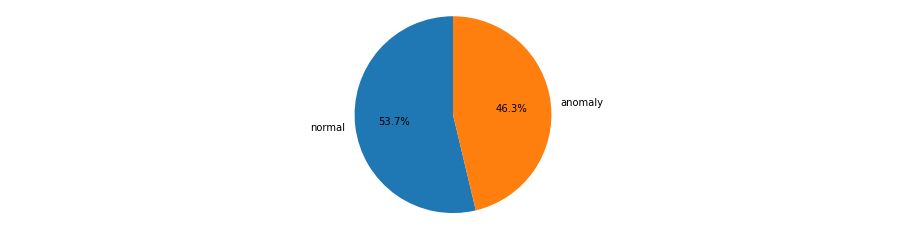

In [ ]:
ratio = test_pred['pred_knn'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(binarize=0.0)
model_knn = KNeighborsClassifier(n_jobs=-1)
model_lr = LogisticRegression()
bnb.fit(X_train, Y_train)
bnb.score(X_test, Y_test)

0.9091089501885294

In [ ]:
pred_bnb = bnb.predict(X_test)
test_pred['pred_bnb'] = pred_bnb
f1_bnb = metrics.f1_score(Y_test, pred_bnb, pos_label="normal")

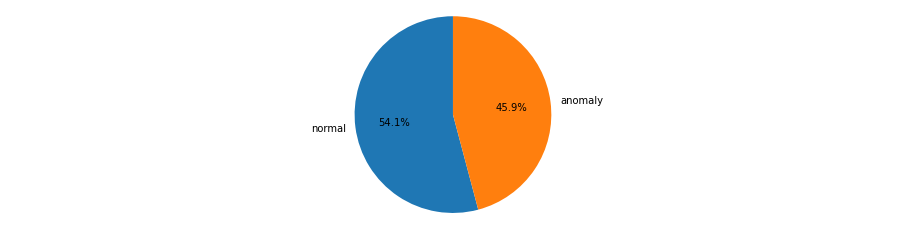

In [ ]:
ratio = test_pred['pred_bnb'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
bnb = BernoulliNB(binarize=0.0)
model_knn = KNeighborsClassifier(n_jobs=-1)
model_lr = LogisticRegression()
rfc.fit(X_train,Y_train)
pred_random = rfc.predict(X_test)
test_pred['pred_random'] = pred_random
f1_random = metrics.f1_score(Y_test, pred_random, pos_label="normal")

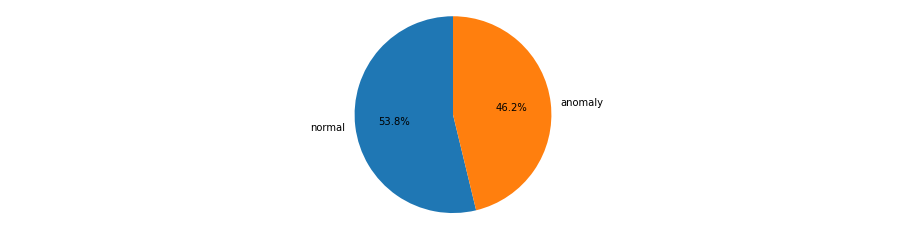

In [ ]:
ratio = test_pred['pred_random'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
from sklearn.svm import SVC
svc = SVC()
rfc = RandomForestClassifier(random_state=0)
bnb = BernoulliNB(binarize=0.0)
model_knn = KNeighborsClassifier(n_jobs=-1)
model_lr = LogisticRegression()
svc.fit(X_train,Y_train)
pred_svc = svc.predict(X_test)
test_pred['pred_svc'] = pred_svc
f1_svc = metrics.f1_score(Y_test, pred_svc, pos_label="normal")

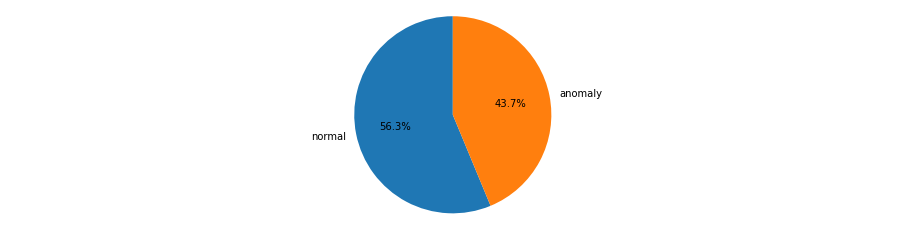

In [ ]:
ratio = test_pred['pred_svc'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
test_pred

,actual,pred_lr,pred_knn,pred_bnb,pred_random,pred_svc
0,anomaly,anomaly,anomaly,anomaly,anomaly,anomaly
1,anomaly,normal,anomaly,normal,anomaly,normal
2,anomaly,anomaly,anomaly,anomaly,anomaly,anomaly
3,anomaly,anomaly,anomaly,anomaly,anomaly,anomaly
4,normal,normal,normal,normal,normal,normal
...,...,...,...,...,...,...
5034,normal,normal,normal,normal,normal,normal
5035,anomaly,anomaly,anomaly,anomaly,anomaly,anomaly
5036,normal,normal,normal,normal,normal,normal
5037,normal,normal,normal,normal,normal,normal


In [ ]:
pred_metrics = {}
pred_metrics['lr'] = f1_lr
pred_metrics['knn'] = f1_knn
pred_metrics['bnb'] = f1_bnb
pred_metrics['random'] = f1_random
pred_metrics['svc'] = f1_svc

In [ ]:
 df_metrics = pandas.DataFrame(pred_metrics.items(), columns=['Classifier', 'F1-score'])

In [ ]:
df_metrics

,Classifier,F1-score
0,lr,0.936240
1,knn,0.977646
2,bnb,0.915716
3,random,0.995199
4,svc,0.960116


<AxesSubplot:xlabel='Classifier', ylabel='F1-score'>

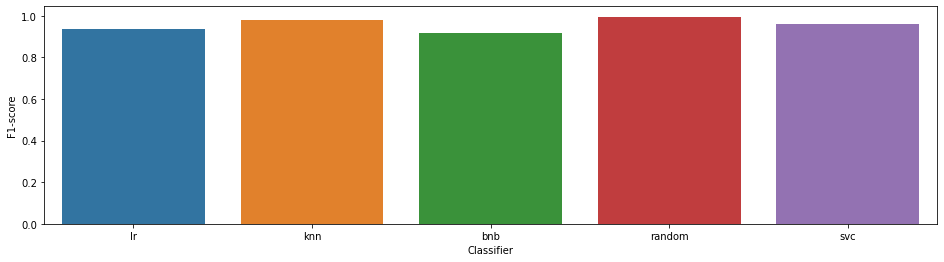

In [ ]:
seaborn.barplot(data=df_metrics, x="Classifier", y="F1-score")

In [ ]:
#Predicting for test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [ ]:
#selected features used
test_subset = test[selected_features]
test_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   src_bytes               22544 non-null  int64  
 1   dst_bytes               22544 non-null  int64  
 2   flag                    22544 non-null  object 
 3   same_srv_rate           22544 non-null  float64
 4   diff_srv_rate           22544 non-null  float64
 5   logged_in               22544 non-null  int64  
 6   dst_host_srv_count      22544 non-null  int64  
 7   count                   22544 non-null  int64  
 8   dst_host_diff_srv_rate  22544 non-null  float64
 9   protocol_type           22544 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 1.7+ MB


In [ ]:
scaler = StandardScaler()

cols = test_subset.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(test_subset.select_dtypes(include=['float64','int64']))

test_subset = pandas.DataFrame(sc_train, columns = cols)

In [ ]:
encoder = LabelEncoder()

test_subset["flag"] = encoder.fit_transform(test["flag"])
test_subset["protocol_type"] = encoder.fit_transform(test["protocol_type"])

In [ ]:
svc = SVC()
rfc = RandomForestClassifier(random_state=0)
bnb = BernoulliNB(binarize=0.0)
model_knn = KNeighborsClassifier(n_jobs=-1)
model_lr = LogisticRegression()

In [ ]:
predictions = pandas.DataFrame()

model_lr.fit(train_x, train_y)
model_knn.fit(train_x, train_y)
bnb.fit(train_x, train_y)
rfc.fit(train_x, train_y)
svc.fit(train_x, train_y)

predictions["Logistic Regression"] = model_lr.predict(test_subset)
predictions["KNN Classifier"] = model_knn.predict(test_subset)
predictions["Naive Bayes Classifier"] = bnb.predict(test_subset)
predictions["Random Forest Classifier"] = rfc.predict(test_subset)
predictions["SVM Classifier"] = svc.predict(test_subset)

In [ ]:
predictions.head()

,Logistic Regression,KNN Classifier,Naive Bayes Classifier,Random Forest Classifier,SVM Classifier
0,anomaly,normal,anomaly,anomaly,normal
1,anomaly,normal,anomaly,anomaly,normal
2,anomaly,anomaly,anomaly,normal,anomaly
3,anomaly,anomaly,anomaly,anomaly,anomaly
4,anomaly,anomaly,anomaly,anomaly,anomaly


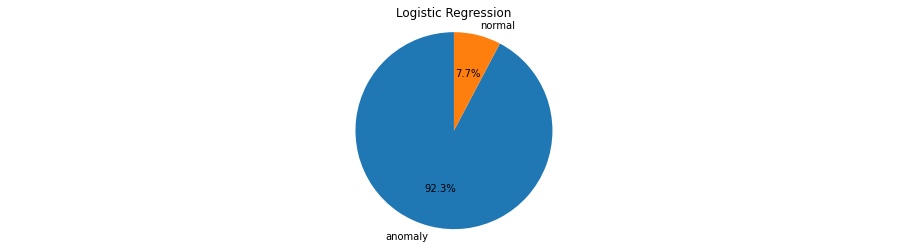

In [ ]:
ratio = predictions['Logistic Regression'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
plt.title("Logistic Regression")
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

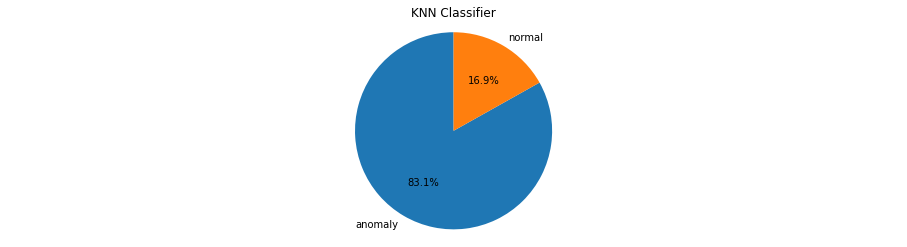

In [ ]:
ratio = predictions['KNN Classifier'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
plt.title("KNN Classifier")
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

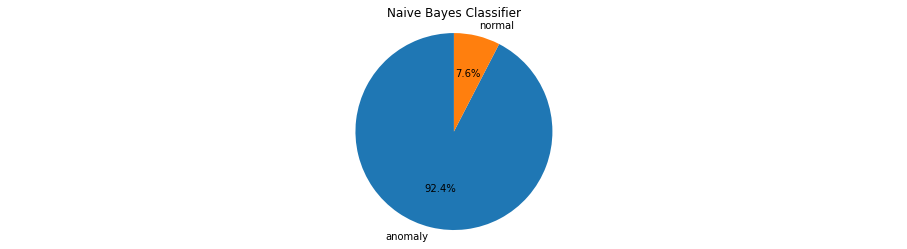

In [ ]:
ratio = predictions['Naive Bayes Classifier'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
plt.title("Naive Bayes Classifier")
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
predictions["Random Forest Classifier"].unique()

array(['anomaly', 'normal'], dtype=object)

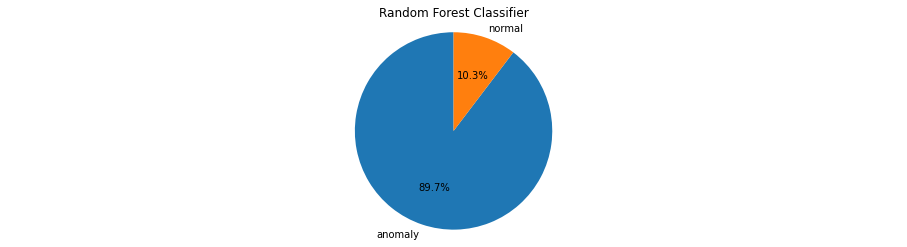

In [ ]:
ratio = predictions['Random Forest Classifier'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
plt.title("Random Forest Classifier")
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

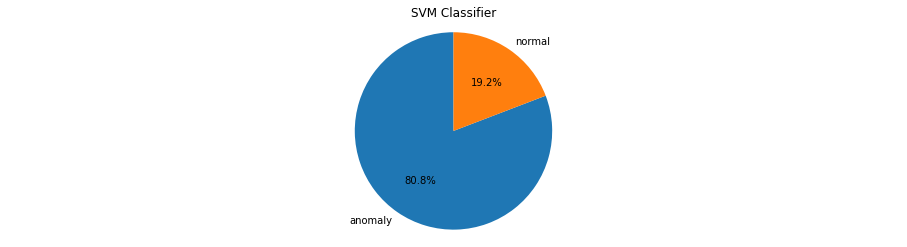

In [ ]:
ratio = predictions['SVM Classifier'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
plt.title("SVM Classifier")
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()